In [2]:
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.manifold import TSNE
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)



In [3]:

df = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                 names=['user_id','item_id','rating','tstamp']).sample(frac=1)
df['date'] = pd.to_datetime(df['tstamp'],unit='s')

print(df.head())
items = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|',
                    names=['movie id' ,'movie title' ,'release date' ,'video release date' ,
                           'IMDb URL' ,'unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western'],encoding='latin')
def get_year(x):
    if pd.isna(x):
        return 0
    else:
        return(int(x[-4:]))
items['year'] = items['release date'].apply(get_year)
items = items.set_index('movie id')
print(items.head)
num_users = len(pd.unique(df['user_id']))
num_movie = len(pd.unique(df['item_id']))

       user_id  item_id  rating     tstamp                date
58343      788      744       4  880869621 1997-11-30 06:00:21
53383      454      961       1  888267279 1998-02-23 20:54:39
61258      353      343       2  891402636 1998-04-01 03:50:36
57846      498      664       5  881955596 1997-12-12 19:39:56
20977       44      946       3  878347847 1997-11-01 01:30:47
<bound method NDFrame.head of                                         movie title release date  \
movie id                                                           
1                                  Toy Story (1995)  01-Jan-1995   
2                                  GoldenEye (1995)  01-Jan-1995   
3                                 Four Rooms (1995)  01-Jan-1995   
4                                 Get Shorty (1995)  01-Jan-1995   
5                                    Copycat (1995)  01-Jan-1995   
...                                             ...          ...   
1678                              Mat' i syn (19

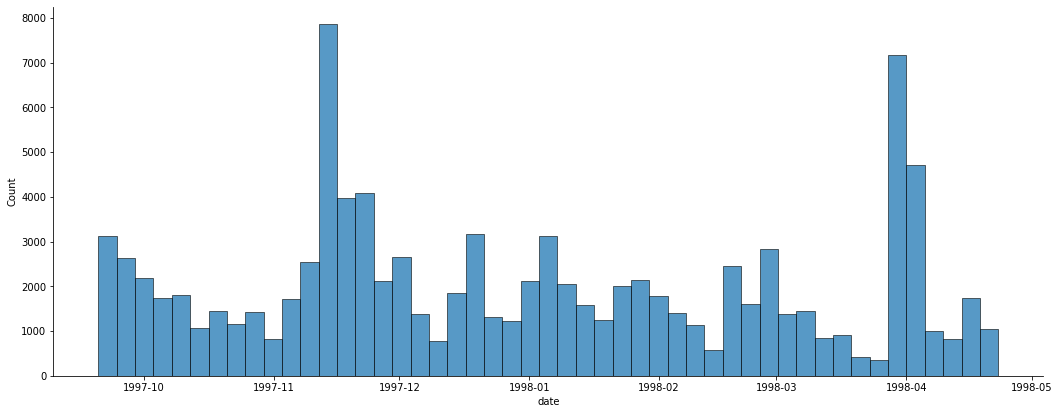

In [3]:
g = sns.displot(df['date'])
g.fig.set_figheight(6)
g.fig.set_figwidth(18)

In [4]:
#Date based split
cutoff_date = '1998-03-01'
df_train = df[df['date'] < cutoff_date]
df_test = df[df['date'] >= cutoff_date]

#Random split
# test_train_split = 0.2
# df_train = df[int(test_train_split*len(df)):]
# df_test = df[:int(test_train_split*len(df))]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

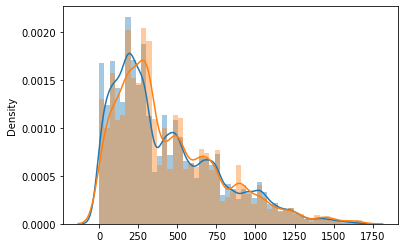

In [5]:
X_train = df_train.drop(columns=['rating','tstamp','date']).to_numpy() - 1
y_train = df_train['rating'].to_numpy()
X_test = df_test.drop(columns=['rating','tstamp','date']).to_numpy() - 1
y_test = df_test['rating'].to_numpy()

sns.distplot(X_train[:,1])
sns.distplot(X_test[:,1])

In [6]:
print(len(np.unique(X_train[:,0])), len(np.unique(X_test[:,0])))
print(len(pd.unique(df['user_id'])))
print(len(np.unique(X_train[:,1])), len(np.unique(X_test[:,1])))
print(len(pd.unique(df['item_id'])))

736 327
943
1608 1467
1682


In [57]:
def collaborative_model(num_users, num_movies, emb_dim):
    x = tf.keras.Input((2))
    x_user = tf.keras.layers.Embedding(num_users,emb_dim,
                                       embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='users')(x[:,0])
    x_movie = tf.keras.layers.Embedding(num_movies,emb_dim,
                                       embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='movies')(x[:,1])
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x, outputs=out, name="colab_model")

model = collaborative_model(num_users,num_movie,32)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=4,
    restore_best_weights=True
)])    
    
umat = model.get_layer('users').get_weights()[0]
mmat = model.get_layer('movies').get_weights()[0]

Epoch 1/40
2194/2194 [==============================] - 4s 2ms/step - loss: 7.3933 - mse: 7.2118 - val_loss: 2.0999 - val_mse: 1.6870
Epoch 2/40
2194/2194 [==============================] - 3s 2ms/step - loss: 1.7481 - mse: 1.2562 - val_loss: 1.6271 - val_mse: 1.0853
Epoch 3/40
2194/2194 [==============================] - 3s 2ms/step - loss: 1.5596 - mse: 0.9927 - val_loss: 1.5910 - val_mse: 1.0070
Epoch 4/40
2194/2194 [==============================] - 4s 2ms/step - loss: 1.5261 - mse: 0.9331 - val_loss: 1.5733 - val_mse: 0.9739
Epoch 5/40
2194/2194 [==============================] - 4s 2ms/step - loss: 1.5094 - mse: 0.9057 - val_loss: 1.5757 - val_mse: 0.9688
Epoch 6/40
2194/2194 [==============================] - 4s 2ms/step - loss: 1.4978 - mse: 0.8880 - val_loss: 1.5687 - val_mse: 0.9549
Epoch 7/40
2194/2194 [==============================] - 4s 2ms/step - loss: 1.4899 - mse: 0.8753 - val_loss: 1.5675 - val_mse: 0.9495
Epoch 8/40
2194/2194 [==============================] - 3s 2ms

In [8]:
#Experiment - how new datapoints including unseen users and movies interact (cold start problem)
#holdout set 
y_pred = model(X_test)
tf.keras.metrics.mean_squared_error(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=11.8153305>

In [10]:
#Experiment - how new datapoints including seen users and movies interact
seen_indices = np.isin(X_test[:,0],X_train[:,0]) & np.isin(X_test[:,1],X_train[:,1])
X_test_seen = X_test[seen_indices]
y_test_seen = y_test[seen_indices]
print(X_test_seen.shape,y_test_seen.shape,X_test.shape)
y_pred = model(X_test_seen)
tf.keras.metrics.mean_squared_error(y_test_seen, y_pred)

(3715, 2) (3715,) (22015, 2)


<tf.Tensor: shape=(), dtype=float32, numpy=1.1567991>

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



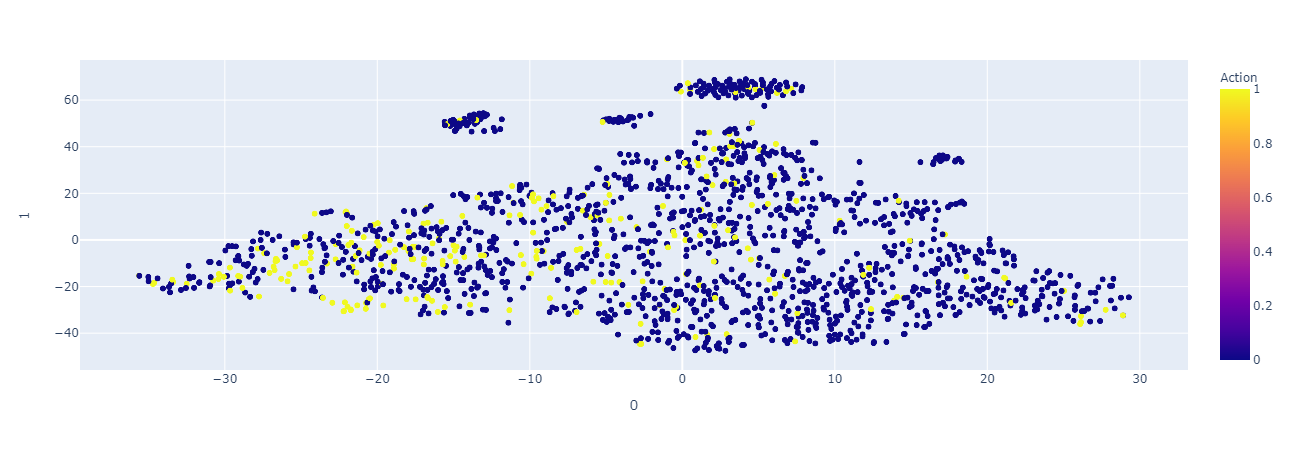

In [58]:
tsne = TSNE()
users = tsne.fit_transform(model.get_layer('users').get_weights()[0])
movies = tsne.fit_transform(model.get_layer('movies').get_weights()[0])
new_df = pd.DataFrame(movies)
new_df[2] = items['movie title'].to_numpy()
new_df.set_index(np.array(new_df.index)+1, inplace = True)
# new_df[3] = items.drop(columns=[0,1,2,3,4]).idxmax(axis=1)
new_df = pd.concat([new_df,items[['release date' ,'video release date' ,
                           'IMDb URL' ,'unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western']]],axis=1)
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='Action')
fig.show()

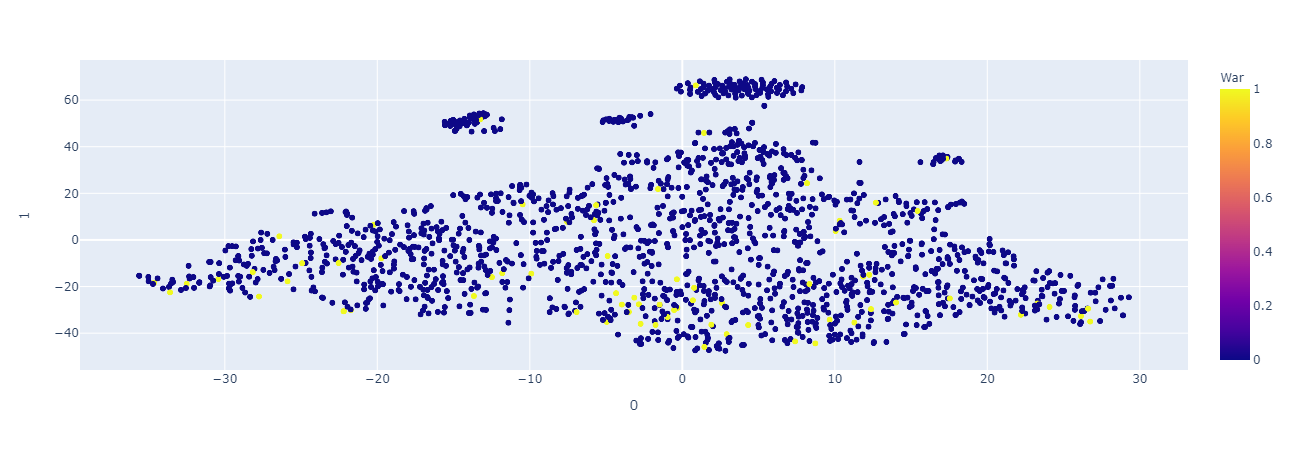

In [61]:
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='War')
fig.show()

In [9]:
def neural_embeddings_collaborative_model(data_dimension, user_data_start_index, emb_dim):
    x_data = tf.keras.Input((data_dimension))
    x_movie_in = x_data[:,:user_data_start_index]
    x_user_in = x_data[:,user_data_start_index:]
    x_user = tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_user_in)
    x_user = tf.keras.layers.Dense(emb_dim,activation='relu')(x_user_in)
    x_movie = tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_movie_in)
    x_movie = tf.keras.layers.Dense(emb_dim,activation='relu')(x_movie_in)
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x_data, outputs=out, name="neural_embeddings_collaborative_model")


net = neural_embeddings_collaborative_model(64,28,32)
net(tf.ones((128,64)))

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
       3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448, 3.2684448,
   

In [ ]:
user_df = df[df[0]==eval_user]
user_df[5] = items.iloc[user_df[1].to_numpy()][1].to_numpy()
print(user_df[user_df[2]>3])

In [ ]:
top_10_sorted_movies = tf.argsort(tf.linalg.matmul(mmat,tf.expand_dims(umat[eval_user,:],axis=1)),
                           axis=0,direction='DESCENDING')[:10,0]
items.iloc[top_10_sorted_movies]

In [ ]:
#Add regularization
#split the data as per time


In [ ]:
import seaborn as sns
sns.displot(items[items['year']>1990]['year'])